<a href="https://colab.research.google.com/github/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/Diffusion_Model_with_Cross_Attention_(teacher).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML from scratch: Stable Diffusion, Day 2

### [Binxu Wang](https://scholar.harvard.edu/binxuw) and [John Vastola](https://twitter.com/johnjvastola)

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/astro.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/ballerina_chasing_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/lovely_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/turtle3.png?raw=true" alt="drawing" width="150"/>
</p>

On the first day, we went over the various components necessary to make an effective diffusion generative model like [Stable Diffusion](https://ommer-lab.com/research/latent-diffusion-models/). 

As a reminder, they are:

- Method of learning to generate new stuff (forward/reverse diffusion)
- Way to link text and images (text-image representation model like [CLIP](https://github.com/openai/CLIP))
- Way to compress images (autoencoder)
- Way to add in good inductive biases (U-net architecture + self/cross-attention)

In today's session, you will implement pieces of each of the above, and by the end have a working Stable-Diffusion-like model. 

In particular, you will implement parts of:

- **basic 1D forward/reverse diffusion**
- **a U-Net architecture for working with images**
- **the loss associated with learning the score function**
- **an attention model for conditional generation**
- **an autoencoder**

We need a reasonably small dataset so that training does not take forever, so we will be working with [MNIST](https://en.wikipedia.org/wiki/MNIST_database), a set of 28x28 images of handwritten 0-9 digits. By the end, our model should be able to take in a number prompt (e.g. "4") and output an image of the digit 4. 

----------------

In [11]:
# !pip install einops
# !pip install lpips

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid


-------------------------------------------

## 1. Basic forward/reverse diffusion 

This section reviews material from the [previous MLFS seminar](https://github.com/DrugowitschLab/ML-from-scratch-seminar/tree/master/DiffusionGenerativeModels) on diffusion generative models. Skip this if you already know the basics!

The gist is that our generative model will work in the following way. We will take our training examples (e.g. images) and corrupt them with noise until they are unrecognizable. Then we will learn to `denoise' them, and potentially turn pure noise into something similar to what we started with. 



### Basic forward diffusion

**Let's start with forward diffusion.** In the simplest case, the relevant diffusion equation is
\begin{equation}
\begin{split}
x(t + \Delta t) = x(t) + \sigma(t) \sqrt{\Delta t} \ r
\end{split}
\end{equation}
where $\sigma(t) > 0$ is the 'noise strength', $\Delta t$ is the step size, and $r \sim \mathcal{N}(0, 1)$ is a standard normal random variable. In essence, we repeatedly add normally-distributed noise to our sample. Often, the noise strength $\sigma(t)$ is chosen to depend on time (i.e. it gets higher as $t$ gets larger).

**Implement the missing part of 1D forward diffusion**.

*Hint: You can use `np.random.randn()` to generate random numbers.*

In [13]:
# Simulate forward diffusion for N steps.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
  """x0: initial sample value, scalar
  noise_strength_fn: function of time, outputs scalar noise strength
  t0: initial time
  nsteps: number of diffusion steps
  dt: time step size
  """

  # Initialize trajectory
  x = np.zeros(nsteps + 1); x[0] = x0
  t = t0 + np.arange(nsteps + 1)*dt 
  
  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    noise_strength = noise_strength_fn(t[i])
    ############ YOUR CODE HERE (2 lines)
    random_normal = np.random.randn()
    x[i+1] = x[i] + np.sqrt(dt)*noise_strength*random_normal
    #####################################
  return x, t


# Example noise strength function: always equal to 1
def noise_strength_constant(t):
  return 1

See if it works by running the code below.

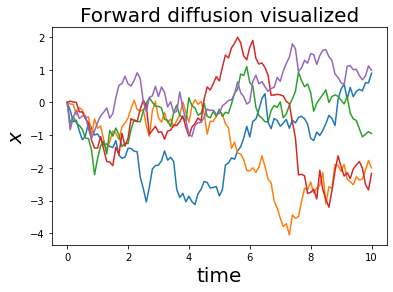

In [14]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
x0 = 0

num_tries = 5
for i in range(num_tries):
  x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)
  
  plt.plot(t, x)
  plt.xlabel('time', fontsize=20)
  plt.ylabel('$x$', fontsize=20)
plt.title('Forward diffusion visualized', fontsize=20)
plt.show()

### Basic reverse diffusion

We can reverse this diffusion process by a similar-looking update rule:
\begin{equation}
x(t + \Delta t) = x(t) + \sigma(T - t)^2 \frac{d}{dx}\left[ \log p(x, T-t) \right] \Delta t + \sigma(T-t) \sqrt{\Delta t} \ r
\end{equation}
where
\begin{equation}
s(x, t) := \frac{d}{dx} \log p(x, t)
\end{equation}
is called the **score function**. If we know this function, we can reverse the forward diffusion and turn noise into what we started with.

If our initial sample is always just one point at $x_0 = 0$, and the noise strength is constant, then the score function is exactly equal to
\begin{equation}
s(x, t) = - \frac{(x - x_0)}{\sigma^2 t} = - \frac{x}{\sigma^2 t} \ .
\end{equation}

**Implement the missing part of 1D reverse diffusion**. You will test it with the above score function.

*Hint: You can use `np.random.randn()` to generate random numbers.*

In [15]:
# Simulate forward diffusion for N steps.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
  """x0: initial sample value, scalar
  noise_strength_fn: function of time, outputs scalar noise strength
  score_fn: score function
  T: final time
  nsteps: number of diffusion steps
  dt: time step size
  """

  # Initialize trajectory
  x = np.zeros(nsteps + 1); x[0] = x0
  t = np.arange(nsteps + 1)*dt 
  
  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    noise_strength = noise_strength_fn(T - t[i])
    score = score_fn(x[i], 0, noise_strength, T-t[i])
    ############ YOUR CODE HERE (2 lines)
    random_normal = np.random.randn()
    x[i+1] = x[i] + (noise_strength**2)*score*dt + np.sqrt(dt)*noise_strength*random_normal
    #####################################
  return x, t


# Example noise strength function: always equal to 1
def score_simple(x, x0, noise_strength, t):
  score = - (x-x0)/((noise_strength**2)*t)
  return score

Run the cell below to see if your implementation works.

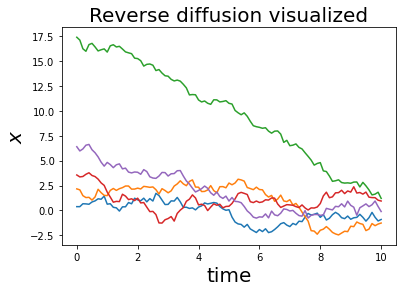

In [16]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
score_fn = score_simple
x0 = 0
T = 11


num_tries = 5
for i in range(num_tries):
  x0 = np.random.normal(loc=0, scale=T)   # draw from the noise distribution, which is diffusion for time T w noise strength 1
  x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)
  
  plt.plot(t, x)
  plt.xlabel('time', fontsize=20)
  plt.ylabel('$x$', fontsize=20)
plt.title('Reverse diffusion visualized', fontsize=20)
plt.show()

### Basic score function learning

In practice, we don't already know the score function; instead, we have to learn it. One way to learn it is to train a neural network to `denoise' samples via the denoising objective
\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0)}\left[ \ \Vert s(x_{noised}, t) \sigma^2(t) + (x_{noised} - x_0)  \Vert^2_2  \ \right]
\end{equation}
where $p_0(x_0)$ is our target distribution (e.g. pictures of cats and dogs), and where $x_{noised}$ is the target distribution sample $x_0$ after one forward diffusion step, i.e. $x_{noised} - x_0$ is just a normally-distributed random variable.

Here's another way of writing the same thing, which is closer to the actual implementation:
\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0), \epsilon \sim \mathcal N(0,I)}\left[ \ \Vert s(x_0 + \sigma(t) \epsilon, t) \sigma^2(t) + \epsilon  \Vert^2_2  \ \right]
\end{equation}
We will implement this for you. But it's good to understand the intuition: we are learning to predict **how much noise was added to each part of our sample**. We should be able to do this well at every time $t$ in the diffusion process, and for every $x_0$ in our original (dogs/cats/etc) distribution.

---------------------

## 2. Working with images via U-Nets

We just reviewed the very basics of diffusion models, with the takeaway that learning the score function allows us to turn pure noise into something interesting. We will learn to approximate the score function with a neural network. But when we are working with images, we need our neural network to 'play nice' with them, and to reflect inductive biases we associate with images.

A reasonable choice is to choose the neural network architecture to be that of a [U-Net](https://en.wikipedia.org/wiki/U-Net), which combines a CNN-like structure with downscaling/upscaling operations that help the network pay attention to features of images at different spatial scales.  

Since the score function we're trying to learn is a function of time, we also need to come up with a way to make sure our neural network properly responds to changes in time. For this purpose, we can use a **time embedding**.

In this section, **you will fill in some missing U-Net pieces.** 

### Helping our neural network work with time

The below code helps our neural network work with time via a **time embedding**. The idea is that, instead of just telling our network one number (the current time), we express the current time in terms of a large number of sinusoidal features. The hope is that, if we tell our network the current time in many different ways, it will more easily respond to changes in time.

This will enable us to successfully learn a time-dependent score function $s(x, t)$. 

In [17]:
#@title Get some modules to let time interact

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization. 
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None] 
    # this broadcast the 2d tensor to 4d, add the same value across space. 


### Defining the U-Net architecture

The below class defines a U-Net architecture. **Fill in the missing pieces.** (This shouldn't be hard; mainly, it's to get you to look at the structure.)

In [18]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

class UNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    
    ########### YOUR CODE HERE (3 lines)
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    #########################
    
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])   
     

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    # Encoding path
    h1 = self.conv1(x)  + self.dense1(embed)   
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    ########## YOUR CODE HERE (2 lines)
    h3 = ...    # conv, dense
    #   apply activation function
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    ############
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

Below is code for an alternate U-Net architecture. Apparently, diffusion models can be successful with somewhat different architectural details. (Note that the differences from the above class are kind of subtle, though.)

* Upper one, **concatenate the tensor from the down block** for skip connection. 
* Lower one, directly **add the tensor from the down blocks** for skip connection. 
  * A special case of the upper

In [19]:
#@title Alternative time-dependent score-based model (double click to expand or collapse)

class UNet_res(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     #  + channels[2]
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)     #  + channels[1]
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1) #  + channels[0]
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    # Encoding path
    h1 = self.conv1(x)  + self.dense1(embed)   
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(h + h3)
    h += self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(h + h2)
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

**Tips**: When you feel uncertain about the shape of the tensors throughout the layers, define the layers outside and see the shapes. This format could be helpful. 

In [20]:
"""
net = nn.Sequential(
    nn.Conv2d(...),
    nn.ConvTranspose2d(...),
)
x = torch.randn(...)
for l in net:
    x = layer(x)
    print(x.shape)
"""

'\nnet = nn.Sequential(\n    nn.Conv2d(...),\n    nn.ConvTranspose2d(...),\n)\nx = torch.randn(...)\nfor l in net:\n    x = layer(x)\n    print(x.shape)\n'

----------------

## 3. Train the U-Net to learn a score function

Let's combine the U-Net we just defined with a way to learn the score function. We need to define a loss function, and then train a neural network in the usual way.

In [21]:
#@title Diffusion constant and noise strength
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

### Defining the loss function

The loss function is mostly defined below. **You need to add one part**: sample random noise with strength `std[:, None, None, None]`, and make sure it has the same shape as $\mathbf{x}$. Then use this to perturb $\mathbf{x}$.

*Hint: `torch.randn_like()` may be useful.*

In [22]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  # Sample time uniformly in 0, 1
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps 
  # Find the noise std at the time `t`
  std = marginal_prob_std(random_t)
  ####### YOUR CODE HERE  (2 lines)
  z = torch.randn_like(x)             # get normally distributed noise
  perturbed_x = x + std[:,None,None,None]*z
  ##############
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

### Defining the sampler

In [23]:
#@title Sampler code
num_steps = 500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
              marginal_prob_std,
              diffusion_coeff, 
              batch_size=64, 
              x_shape=(1, 28, 28),
              num_steps=num_steps, 
              device='cuda', 
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

### Training on MNIST

We will train on MNIST, and learn to generate pictures that look like 0-9 digits. No code to fill in here; just run it and see if it works!

In the following code, the loss could descent to ~ 40-50. 

In [24]:
#@title Training (double click to expand or collapse)

score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  2048 #@param {'type':'integer'}
## learning rate
lr=5e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in tqdm(data_loader):
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In the following code, the loss could descent to ~ 25, with relatively good quality. 

In [25]:
#@title Training the alternate U-Net model (double click to expand or collapse)

score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   75#@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt_res.pth')

  0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 669.820443 lr 9.8e-04
1 Average Loss: 207.786559 lr 9.6e-04
2 Average Loss: 141.936716 lr 9.4e-04
3 Average Loss: 110.786338 lr 9.2e-04
4 Average Loss: 92.772366 lr 9.0e-04
5 Average Loss: 80.483351 lr 8.9e-04
6 Average Loss: 71.819355 lr 8.7e-04
7 Average Loss: 65.338787 lr 8.5e-04
8 Average Loss: 60.675958 lr 8.3e-04
9 Average Loss: 55.926443 lr 8.2e-04
10 Average Loss: 52.940381 lr 8.0e-04
11 Average Loss: 50.015789 lr 7.8e-04
12 Average Loss: 47.818353 lr 7.7e-04
13 Average Loss: 45.353871 lr 7.5e-04
14 Average Loss: 43.532223 lr 7.4e-04
15 Average Loss: 41.779030 lr 7.2e-04
16 Average Loss: 40.448848 lr 7.1e-04
17 Average Loss: 39.156774 lr 7.0e-04
18 Average Loss: 37.950074 lr 6.8e-04
19 Average Loss: 37.101015 lr 6.7e-04
20 Average Loss: 36.076210 lr 6.5e-04
21 Average Loss: 35.369582 lr 6.4e-04
22 Average Loss: 34.217154 lr 6.3e-04
23 Average Loss: 33.574553 lr 6.2e-04
24 Average Loss: 33.365638 lr 6.0e-04
25 Average Loss: 32.633655 lr 5.9e-04
26 Average Loss: 3

Visualize the results of training below.

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


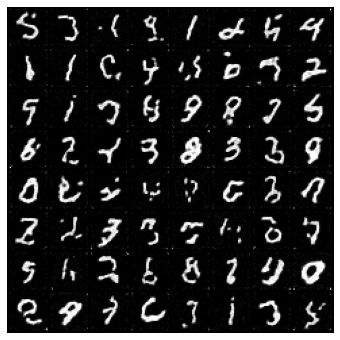

In [26]:

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 500 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
          marginal_prob_std_fn,
          diffusion_coeff_fn, 
          sample_batch_size, 
          num_steps=num_steps,
          device=device,
          y=None)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


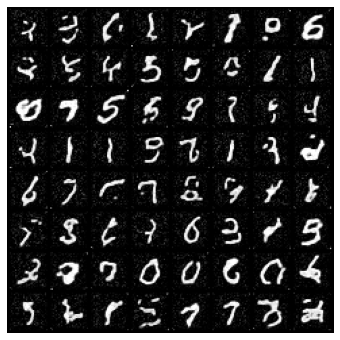

In [27]:
def save_samples_uncond(score_model, suffix=""):
  score_model.eval()
  ## Generate samples using the specified sampler.
  sample_batch_size = 64 #@param {'type':'integer'}
  num_steps = 250 #@param {'type':'integer'}
  sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
  # score_model.eval()
  ## Generate samples using the specified sampler.
  samples = sampler(score_model, 
          marginal_prob_std_fn,
          diffusion_coeff_fn, 
          sample_batch_size, 
          num_steps=num_steps,
          device=device,
          )

      ## Sample visualization.
  samples = samples.clamp(0.0, 1.0)
  sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
  sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
  plt.imsave(f"uncondition_diffusion{suffix}.png", sample_np,)
  plt.figure(figsize=(6,6))
  plt.axis('off')
  plt.imshow(sample_np, vmin=0., vmax=1.)
  plt.show()

uncond_score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
uncond_score_model.load_state_dict(torch.load("ckpt_res.pth"))
save_samples_uncond(uncond_score_model, suffix="_res")

----------------------

## 4. Using attention to get conditional generation to work

In addition to generating images of e.g. 0-9 digits, we would like to do *conditional* generation: we would like to *specify* which digit we would like to generate an image of, for example. 

Attention models, while not strictly necessary for conditional generation, have proven useful for getting it to work well. In this section, you will implement parts of an attention model.

In [28]:
from einops import rearrange
import math

### "Word embedding" of digits

Here, instead of using a fancy CLIP model, we just define our own vector representations of the digits 0-9. 

We used the `nn.Embedding` layer to turn 0-9 index into vectors. 

In [29]:
class WordEmbed(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(WordEmbed, self).__init__()
    self.embed = nn.Embedding(vocab_size+1, embed_dim)
  
  def forward(self, ids):
    return self.embed(ids)

### Let's develop our Attention layer

We usually implement attention models using 3 parts:
* `CrossAttention`  Write a module to do self / cross attention for **sequences**. 
* `TransformerBlock`  Combine self/cross-attention and a feed-forward neural network. 
* `SpatialTransformer`  To use attention in a U-net, transform the spatial tensor to a sequential tensor and back. 

**You will implement a part of the CrossAttention class**, and you will also pick where to add attention in your U-Net.

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/attention_pic1.png?raw=true" alt="drawing" width="850"/>
</p>

Here's a brief review of the mathematics of attention models. [QKV (query-key-value) attention models](https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms) represent queries, keys, and values as vectors. These are tools that help us relate words/images on one side of a translation task to the other side.

These are linearly related to $\mathbf{e}$ vectors (which represent the hidden state of the encoder) and $\mathbf{h}$ vectors (which represent the hidden state of the decoder):

\begin{equation}
\begin{split}
\mathbf{q}_i &= W_q \mathbf{h}_i \\
\mathbf{k}_j &= W_k \mathbf{e}_j \\
\mathbf{v}_j &= W_v \mathbf{e}_j \ .
\end{split}
\end{equation}

To figure out what to 'pay attention' to, we compute the inner product (i.e. similarity) of each key $\mathbf{k}$ and query $\mathbf{q}$. To get typical values that are not too big or too small, we normalize by the length/dimension of the query vectors $\mathbf{q}_i$. 

The final attention distribution comes from softmax-ing all of this:

\begin{equation}
\begin{split}
a_{ij} &= \text{SoftMax}\left( \frac{\mathbf{k}_j \cdot \mathbf{q}_i}{\sqrt{\text{len}(\mathbf{q}_i)}} \right) \\
\sum_j a_{ij} &= 1 
\end{split}
\end{equation}

The attention distribution is used to pick out some relevant combination of features. For example, in translating the phrase "European Union" from English to French, getting the correct answer ("Union européenne") requires paying attention to both words at once, instead of trying to translate each word totally separately. Mathematically, we weight values $\mathbf{v}_j$ by the attention distribution:

\begin{equation}
\mathbf{c}_i := \sum_j a_{ij} \mathbf{v}_j
\end{equation}

**Implement the missing pieces of the CrossAttention class below. Also implement the missing part of the TransformerBlock class.**

Note that the relevant matrix multiplications can be performed using `torch.einsum`. For example, to multiply an $M \times N$ matrix $A$ together with an $N \times N$ matrix $B$, i.e. to obtain $A B$, we can write:

`torch.einsum(ij,jk -> ik ,A, B)`

If, instead, we wanted to compute $A B^T$, we could write

`torch.einsum(ij,kj->ik ,A, B)`

The library takes care of moving the dimensions around properly. For machine learning, it is often important to do operations like matrix multiplication in batches. In this case, you can might have tensors instead of matrices, but you can write a very similar expression:

`torch.einsum(bij,bkj ,A, B)`

where `b` here is the index that describes which batch elements we are talking about. As a final point, you can use whatever letters you like instead of `i`, `j`, etc.

*Hint: `F.softmax` may also be helpful!*

### Attention Modules

In [30]:
class CrossAttention(nn.Module):
  def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1,):
    """
    Note: For simplicity reason, we just implemented 1-head attention. 
    Feel free to implement multi-head attention! with fancy tensor manipulations.
    """
    super(CrossAttention, self).__init__()
    self.hidden_dim = hidden_dim
    self.context_dim = context_dim
    self.embed_dim = embed_dim
    self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
    if context_dim is None:
      self.self_attn = True 
      self.key = nn.Linear(hidden_dim, embed_dim, bias=False)     ###########
      self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)  ############
    else:
      self.self_attn = False 
      self.key = nn.Linear(context_dim, embed_dim, bias=False)   #############
      self.value = nn.Linear(context_dim, hidden_dim, bias=False) ############
    
    
  def forward(self, tokens, context=None):
    # tokens: with shape [batch, sequence_len, hidden_dim]
    # context: with shape [batch, contex_seq_len, context_dim]
    if self.self_attn:
        Q = self.query(tokens)
        K = self.key(tokens)  
        V = self.value(tokens) 
    else:
        # implement Q, K, V for the Cross attention 
        Q = self.query(tokens)
        K = self.key(context)
        V = self.value(context)
    #print(Q.shape, K.shape, V.shape)
    ####### YOUR CODE HERE (2 lines)
    scoremats = torch.einsum("BTH,BSH->BTS", Q, K)         # inner product of Q and K, a tensor 
    attnmats = F.softmax(scoremats/np.sqrt(self.embed_dim), dim=-1)          # softmax of scoremats
    #print(scoremats.shape, attnmats.shape, )
    ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # weighted average value vectors by attnmats
    return ctx_vecs


class TransformerBlock(nn.Module):
  """The transformer block that combines self-attn, cross-attn and feed forward neural net"""
  def __init__(self, hidden_dim, context_dim):
    super(TransformerBlock, self).__init__()
    self.attn_self = CrossAttention(hidden_dim, hidden_dim, )
    self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

    self.norm1 = nn.LayerNorm(hidden_dim)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.norm3 = nn.LayerNorm(hidden_dim)
    # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
    self.ffn  = nn.Sequential(nn.Linear(hidden_dim, 3*hidden_dim),
                nn.GELU(), nn.Linear(3*hidden_dim, hidden_dim) )
    
    
  def forward(self, x, context=None):
    # Notice the + x as residue connections
    x = self.attn_self(self.norm1(x)) + x
    # Notice the + x as residue connections
    x = self.attn_cross(self.norm2(x), context=context) + x
    # Notice the + x as residue connections
    x = self.ffn(self.norm3(x)) + x
    return x 

class SpatialTransformer(nn.Module):
  def __init__(self, hidden_dim, context_dim):
    super(SpatialTransformer, self).__init__()
    self.transformer = TransformerBlock(hidden_dim, context_dim)

  def forward(self, x, context=None):
    b, c, h, w = x.shape
    x_in = x
    # Combine the spatial dimensions and move the channel dimen to the end
    x = rearrange(x, "b c h w->b (h w) c")
    # Apply the sequence transformer
    x = self.transformer(x, context)
    # Reverse the process
    x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
    # Residue 
    return x + x_in

Code play ground!

### Putting it together, UNet Transformer

Now you can interleave your `SpatialTransformer` layers with the convolutional layers! 

Remember to use them in your forward function. **Look at the architecture, and add in extra attention layers if you wish.**

In [31]:
class UNet_Tranformer(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, 
               text_dim=256, nClass=10):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings of time.
      text_dim:  the embedding dimension of text / digits. 
      nClass:    number of classes you want to model.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim)
        )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.attn3 = SpatialTransformer(channels[2], text_dim) 
    
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    
    # YOUR CODE: interleave some attention layers with conv layers
    self.attn4 = SpatialTransformer(channels[3], text_dim)                        ######################################

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])   

    self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     #  + channels[2]
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    
    self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)     #  + channels[1]
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1) #  + channels[0]
    
    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    self.cond_embed = nn.Embedding(nClass, text_dim)
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    y_embed = self.cond_embed(y).unsqueeze(1)
    # Encoding path
    h1 = self.conv1(x) + self.dense1(embed) 
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h3 = self.attn3(h3, y_embed) # Use your attention layers
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))
    # Your code: Use your additional attention layers! 
    h4 = self.attn4(h4, y_embed)       ##################### ATTENTION LAYER COULD GO HERE IF ATTN4 IS DEFINED

    # Decoding path
    h = self.tconv4(h4) + self.dense5(embed)
    ## Skip connection from the encoding path
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(h + h3) + self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(h + h2) + self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

### Conditional Denoising Loss

Here, we need to modify the loss function by using the `y` information in the training. 

In [32]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t, y=y)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

### Training a model that includes attention

The below code, similar to code above, does the training.

In [33]:
#@title Training model

continue_training = False #@param {type:"boolean"}
if not continue_training:
  print("initilize new score model...")
  score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
  score_model = score_model.to(device)


n_epochs =   100#@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in tqdm(data_loader):
    x = x.to(device)    
    loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

initilize new score model...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 953.572272 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 253.768291 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 164.376464 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 123.526899 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 99.061638 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 82.770933 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 71.860737 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 63.755011 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 58.300188 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 53.988127 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 50.500567 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 47.759629 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 45.329512 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 44.009029 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 42.308811 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 41.029416 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 40.493244 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 39.257141 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 38.360430 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 37.574849 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 36.553499 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 36.380295 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 35.637978 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 34.760831 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 34.389716 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 33.386967 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 33.452872 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 32.402453 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 32.255543 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 31.727377 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 31.479514 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 31.042575 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 30.553296 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 30.054700 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 30.300837 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 29.422712 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 29.167948 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 29.015835 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 28.839245 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 28.593546 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 27.962041 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 27.906451 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 27.691654 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 27.611342 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 27.248949 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 27.320882 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 26.947725 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 26.654756 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 26.568407 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 26.310686 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 26.135513 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 26.072518 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 26.021929 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 25.744616 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 25.743794 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 25.548458 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 25.061041 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 24.871957 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 25.210634 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 24.655898 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 24.749471 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 24.558400 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 24.647442 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 24.517597 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 24.069120 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 24.384366 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 24.408786 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 23.936238 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 24.005147 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 23.684099 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 23.632241 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 23.482349 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 23.409975 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 23.450279 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 23.281570 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 23.123580 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 23.355241 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 23.062510 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 22.966272 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 22.925824 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 22.574407 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 22.308450 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 22.456076 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 22.562760 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 22.572612 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 22.495736 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 22.522246 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 22.096360 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 22.077967 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 21.986395 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 22.048014 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 21.990077 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 22.074050 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 21.956136 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 21.840822 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 21.484644 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 21.757961 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 21.444701 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 21.611210 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 21.448437 lr 2.0e-04


Loss around 23 at 67 epochs (without lr tuning, around 150 epochs reach 23)

In [34]:
#@title A handy training function
def train_diffusion_model(dataset,
                          score_model,
                          n_epochs =   100,
                          batch_size =  1024,
                          lr=10e-4,
                          model_name="transformer"):

  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

  optimizer = Adam(score_model.parameters(), lr=lr)
  scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
  tqdm_epoch = trange(n_epochs)
  for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in tqdm(data_loader):
      x = x.to(device)    
      loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
      optimizer.zero_grad()
      loss.backward()    
      optimizer.step()
      avg_loss += loss.item() * x.shape[0]
      num_items += x.shape[0]
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), f'ckpt_{model_name}.pth')

In [35]:
# Feel free to play with hyperparameters for training!
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
train_diffusion_model(dataset, score_model,
                      n_epochs =   100,
                      batch_size =  1024,
                      lr=10e-4,
                      model_name="transformer")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 1169.850742 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 315.815048 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 207.327033 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 156.847362 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 126.546722 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 107.298927 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 93.522450 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 82.844085 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 75.193786 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 68.748250 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 64.058873 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 60.214785 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 56.816593 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 53.600726 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 51.074029 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 48.537899 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 46.774564 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 44.556527 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 43.447579 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 41.760571 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 40.201811 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 39.653488 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 38.583664 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 37.265139 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 36.634418 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 35.772203 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 35.105257 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 34.436924 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 34.304728 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 33.389521 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 32.778647 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 32.356311 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 31.915862 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 31.585867 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 31.070708 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 30.890161 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 30.157016 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 29.882116 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 29.812984 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 29.240592 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 29.223138 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 28.691495 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 28.561431 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 28.330400 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 28.185139 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 27.944946 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 27.655127 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 27.435800 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 27.150750 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 27.063304 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 26.778796 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 26.563733 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 26.386302 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 26.383381 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 26.212721 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 26.176843 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 25.921417 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 25.656892 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 25.583083 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 25.253353 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 25.152582 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 24.999621 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 24.836358 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 24.915254 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 24.653404 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 24.561200 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 24.547489 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 24.217462 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 24.323365 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 23.806092 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 23.804114 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 24.149117 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 24.055556 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 23.760330 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 23.815026 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 23.605016 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 23.423807 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 23.495199 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 23.144559 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 23.153638 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 23.144228 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 23.009353 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 22.934136 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 22.811259 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 22.678989 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 22.704479 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 22.383812 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 22.572401 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 22.260433 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 22.342171 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 22.347376 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 22.192800 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 22.324738 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 22.082987 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 21.895981 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 22.023090 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 21.911318 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 21.828351 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 21.721502 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 21.545342 lr 2.0e-04


In [36]:

def visualize_digit_embedding(digit_embed):
  cossim_mat = []
  for i in range(10):
    cossim = torch.cosine_similarity(digit_embed, digit_embed[i:i+1,:]).cpu()
    cossim_mat.append(cossim)
  cossim_mat = torch.stack(cossim_mat)
  cossim_mat_nodiag = cossim_mat + torch.diag_embed(torch.nan * torch.ones(10))
  plt.imshow(cossim_mat_nodiag)
  plt.show()
  return cossim_mat

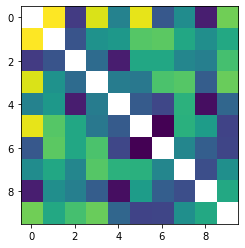

In [37]:
cossim_mat = visualize_digit_embedding(score_model.module.cond_embed.weight.data)

### Examine Samples

Here is some code we can use to see how well the model does conditional generation. You can use the menu on the right to choose what you want to generate.

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


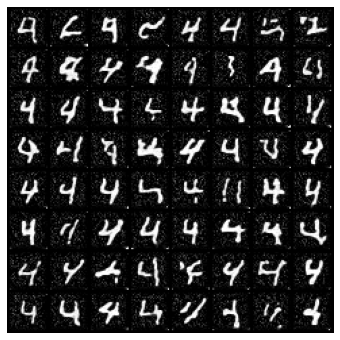

In [38]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)
digit = 4 #@param {'type':'integer'}
sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 250 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()
## Generate samples using the specified sampler.
samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [39]:
def save_samples_cond(score_model, suffix):
  score_model.eval()
  for digit in range(10):
    ## Generate samples using the specified sampler.
    sample_batch_size = 64 #@param {'type':'integer'}
    num_steps = 500 #@param {'type':'integer'}
    sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
    # score_model.eval()
    ## Generate samples using the specified sampler.
    samples = sampler(score_model, 
            marginal_prob_std_fn,
            diffusion_coeff_fn, 
            sample_batch_size, 
            num_steps=num_steps,
            device=device,
            y=digit*torch.ones(sample_batch_size, dtype=torch.long))

        ## Sample visualization.
    samples = samples.clamp(0.0, 1.0)
    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
    sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
    plt.imsave(f"condition_diffusion{suffix}_digit%d.png"%digit, sample_np,)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_np, vmin=0., vmax=1.)
    plt.show()


/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


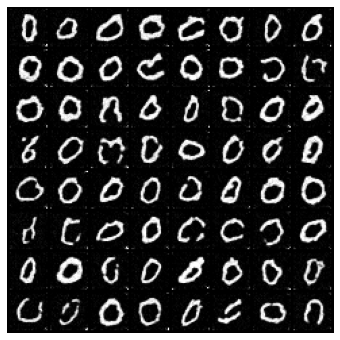

  0%|          | 0/500 [00:00<?, ?it/s]

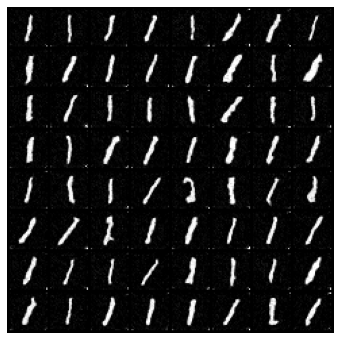

  0%|          | 0/500 [00:00<?, ?it/s]

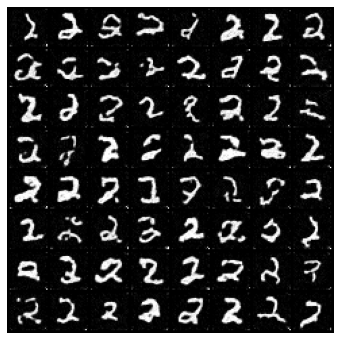

  0%|          | 0/500 [00:00<?, ?it/s]

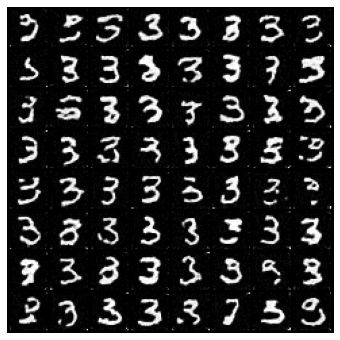

  0%|          | 0/500 [00:00<?, ?it/s]

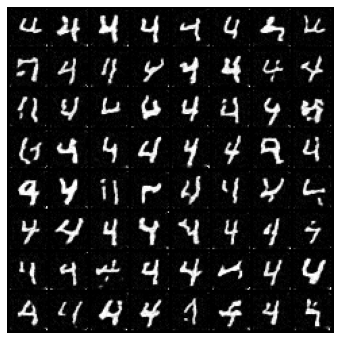

  0%|          | 0/500 [00:00<?, ?it/s]

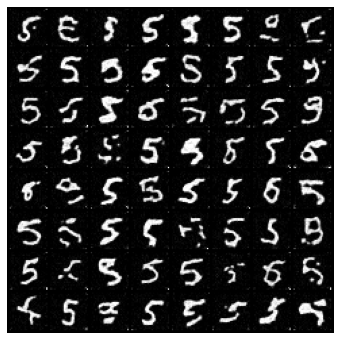

  0%|          | 0/500 [00:00<?, ?it/s]

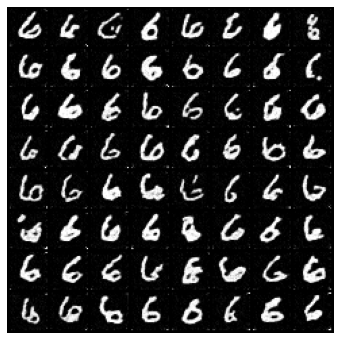

  0%|          | 0/500 [00:00<?, ?it/s]

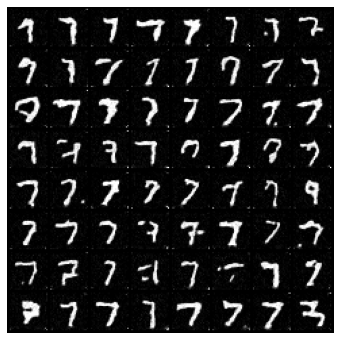

  0%|          | 0/500 [00:00<?, ?it/s]

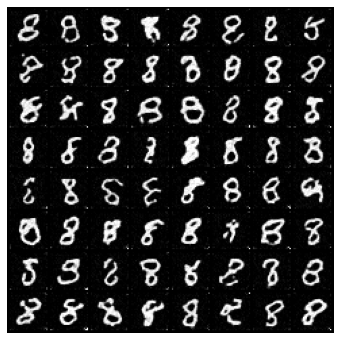

  0%|          | 0/500 [00:00<?, ?it/s]

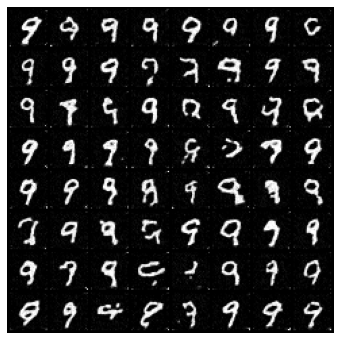

In [40]:
save_samples_cond(score_model,"_res") # model with res connection

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


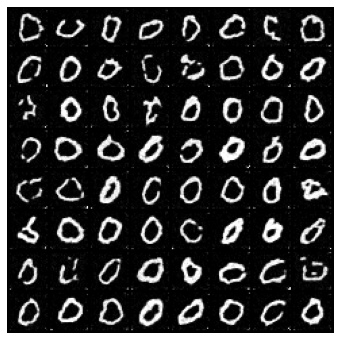

  0%|          | 0/500 [00:00<?, ?it/s]

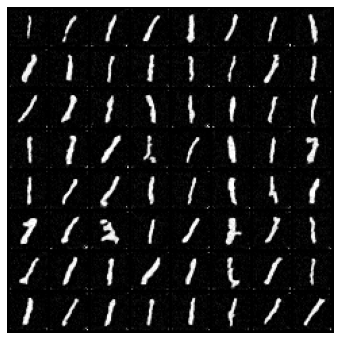

  0%|          | 0/500 [00:00<?, ?it/s]

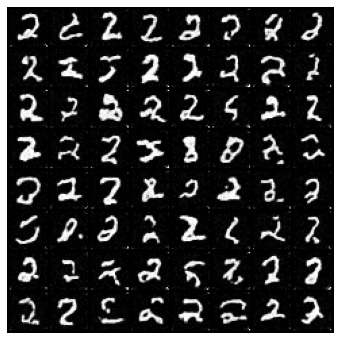

  0%|          | 0/500 [00:00<?, ?it/s]

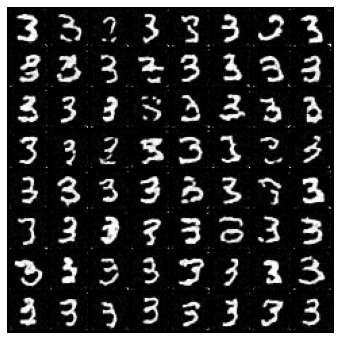

  0%|          | 0/500 [00:00<?, ?it/s]

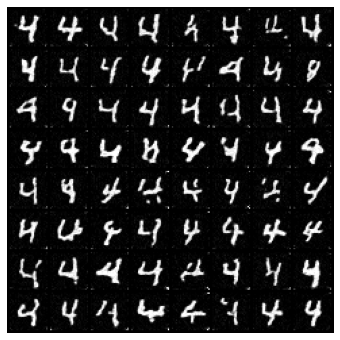

  0%|          | 0/500 [00:00<?, ?it/s]

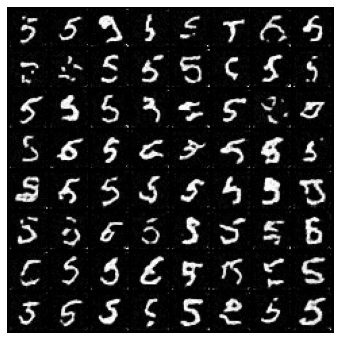

  0%|          | 0/500 [00:00<?, ?it/s]

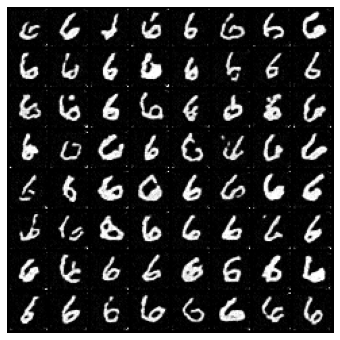

  0%|          | 0/500 [00:00<?, ?it/s]

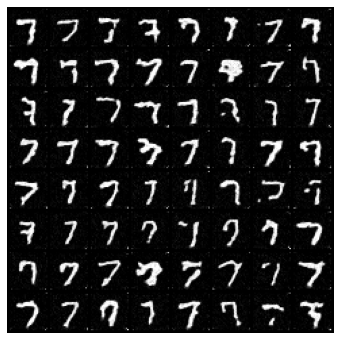

  0%|          | 0/500 [00:00<?, ?it/s]

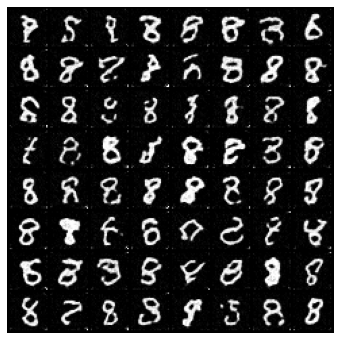

  0%|          | 0/500 [00:00<?, ?it/s]

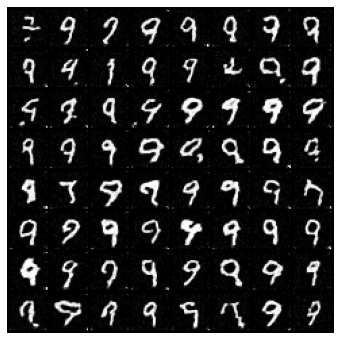

In [42]:
save_samples_cond(score_model, suffix="test_1") # model without res connection

--------------------

## 5. Latent space diffusion using an autoencoder

Finally, we get to one of the most important contributions of [Rombach et al.](https://ommer-lab.com/research/latent-diffusion-models/), the paper behind Stable Diffusion! Instead of diffusing in pixel space (i.e. corrupting and denoising each pixel of an image), we can try diffusing in some kind of *latent space*. 

This has a few advantages. An obvious one is speed: compressing images before doing forward/reverse diffusion on them makes both generation and training faster. Another advantage is that the latent space, if carefully chosen, may be a more natural or interpretable space for working with images. For example, given a set of pictures of heads, perhaps some latent direction corresponds to head direction. 

If we do not have any a priori bias towards one latent space or another, we can just throw an autoencoder at the problem and hope it comes up with something appropriate. 

In this section, **we will use an autoencoder to compress MNIST images to a smaller scale**, and glue this to the rest of our diffusion pipeline.

### Defining the autoencoder

**Complete the missing part of the autoencoder's forward function**. Note that what an autoencoder does is first 'encode' an image into some latent representation, and then 'decode' an image from that latent representation. 

*Hint: You can access the encoder and decoder via `self.encoder` and `self.decoder`.*

In [43]:
class AutoEncoder(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[4, 8, 32],):
    """Initialize a time-dependent score-based network.
    Args:
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    # Encoding layers where the resolution decreases
    self.encoder = nn.Sequential(nn.Conv2d(1, channels[0], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[0]),
                   nn.SiLU(),
                   nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=True),
                   nn.BatchNorm2d(channels[1]),
                   nn.SiLU(),
                   nn.Conv2d(channels[1], channels[2], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[2]),
                   ) #nn.SiLU(),
    self.decoder = nn.Sequential(nn.ConvTranspose2d(channels[2], channels[1], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[1]),
                   nn.SiLU(),
                   nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=True, output_padding=1),
                   nn.BatchNorm2d(channels[0]),
                   nn.SiLU(),
                   nn.ConvTranspose2d(channels[0], 1, 3, stride=1, bias=True),
                   nn.Sigmoid(),)
  
  def forward(self, x):
    ########## YOUR CODE HERE (1 line)
    output = self.decoder(self.encoder(x))
    ###################
    return output

The following code checks to see whether your autoencoder was defined properly.

In [44]:
x_tmp = torch.randn(1,1,28,28)
print(AutoEncoder()(x_tmp).shape)
assert AutoEncoder()(x_tmp).shape == x_tmp.shape, "Check conv layer spec! the autoencoder input output shape not align"

torch.Size([1, 1, 28, 28])


### Train the autoencoder with the help of a perceptual loss

Let's train the autoencoder on MNIST images! Do this by running the cells below.

The loss could be really small ~ close to 0.01

In [45]:
from lpips import LPIPS

In [46]:
# Define the loss function, MSE and LPIPS 
lpips = LPIPS(net="squeeze").cuda()
loss_fn_ae = lambda x,xhat: \
    nn.functional.mse_loss(x, xhat) + \
    lpips(x.repeat(1,3,1,1), x_hat.repeat(1,3,1,1)).mean()

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


/home/frank/anaconda3/envs/tf_1_12_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/frank/anaconda3/envs/tf_1_12_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /home/frank/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

Loading model from: /home/frank/anaconda3/envs/tf_1_12_gpu/lib/python3.8/site-packages/lpips/weights/v0.1/squeeze.pth


In [47]:
ae_model = AutoEncoder([4, 4, 4]).cuda()
n_epochs =   50  #@param {'type':'integer'}
## size of a mini-batch
batch_size =  2048   #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

optimizer = Adam(ae_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    z = ae_model.encoder(x)
    x_hat = ae_model.decoder(z)
    loss = loss_fn_ae(x, x_hat) #loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  print('{} Average Loss: {:5f}'.format(epoch, avg_loss / num_items))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(ae_model.state_dict(), 'ckpt_ae.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

0 Average Loss: 0.646375
1 Average Loss: 0.448958
2 Average Loss: 0.316626
3 Average Loss: 0.222236
4 Average Loss: 0.167588
5 Average Loss: 0.135677
6 Average Loss: 0.111976
7 Average Loss: 0.093503
8 Average Loss: 0.078271
9 Average Loss: 0.064817
10 Average Loss: 0.052669
11 Average Loss: 0.042623
12 Average Loss: 0.034908
13 Average Loss: 0.029558
14 Average Loss: 0.025875
15 Average Loss: 0.023229
16 Average Loss: 0.021260
17 Average Loss: 0.019749
18 Average Loss: 0.018552
19 Average Loss: 0.017587
20 Average Loss: 0.016780
21 Average Loss: 0.016088
22 Average Loss: 0.015487
23 Average Loss: 0.014960
24 Average Loss: 0.014497
25 Average Loss: 0.014082
26 Average Loss: 0.013704
27 Average Loss: 0.013362
28 Average Loss: 0.013041
29 Average Loss: 0.012746
30 Average Loss: 0.012470
31 Average Loss: 0.012213
32 Average Loss: 0.011970
33 Average Loss: 0.011745
34 Average Loss: 0.011536
35 Average Loss: 0.011335
36 Average Loss: 0.011145
37 Average Loss: 0.010967
38 Average Loss: 0.010

In [48]:
x_hat.shape

torch.Size([608, 1, 28, 28])

The below cell visualizes the results. The autoencoder's output should look almost identical to the original images.

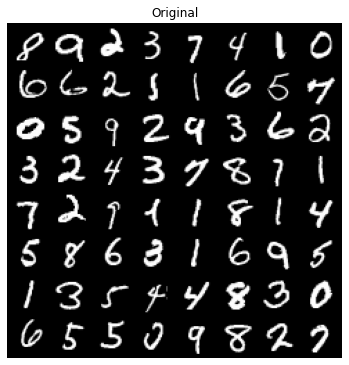

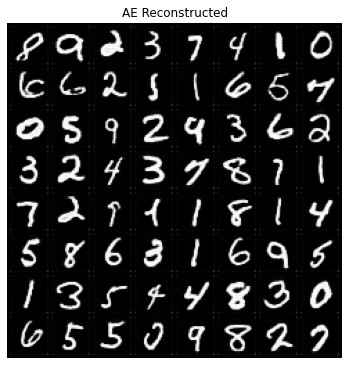

In [49]:
#@title Visualize trained autoencoder
ae_model.eval()
x, y = next(iter(data_loader))
x_hat = ae_model(x.to(device)).cpu()
plt.figure(figsize=(6,6.5))
plt.axis('off')
plt.imshow(make_grid(x[:64,:,:,:].cpu()).permute([1,2,0]), vmin=0., vmax=1.)
plt.title("Original")
plt.show()

plt.figure(figsize=(6,6.5))
plt.axis('off')
plt.imshow(make_grid(x_hat[:64,:,:,:].cpu()).permute([1,2,0]), vmin=0., vmax=1.)
plt.title("AE Reconstructed")
plt.show()

### Create latent state dataset

Let's use our autoencoder to convert MNIST images into a latent space representation. We will use these compressed images to train our diffusion generative model.

In [50]:
batch_size = 4096
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
ae_model.requires_grad_(False)
ae_model.eval()
zs = []
ys = []
for x, y in tqdm(data_loader):
  z = ae_model.encoder(x.to(device)).cpu()
  zs.append(z)
  ys.append(y)

zdata = torch.cat(zs, )
ydata = torch.cat(ys, )

  0%|          | 0/15 [00:00<?, ?it/s]

In [51]:
print(zdata.shape)
print(ydata.shape)
print(zdata.mean(), zdata.var())

torch.Size([60000, 4, 10, 10])
torch.Size([60000])
tensor(-0.0460) tensor(0.9146)


In [52]:
from torch.utils.data import TensorDataset
latent_dataset = TensorDataset(zdata, ydata)

### Transformer UNet model for Latents

Here is a U-Net (that includes self/cross-attention) similar to the one we defined before, but that this time works with compressed images instead of full-size images. You don't need to do anything here except take a look at the architecture.

In [53]:
class Latent_UNet_Tranformer(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[4, 64, 128, 256], embed_dim=256, 
               text_dim=256, nClass=10):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(channels[0], channels[1], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[1])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[1])
    self.conv2 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[2])
    self.gnorm2 = nn.GroupNorm(4, num_channels=channels[2])
    self.attn2 = SpatialTransformer(channels[2], text_dim)
    self.conv3 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[3])
    self.gnorm3 = nn.GroupNorm(4, num_channels=channels[3])   
    self.attn3 = SpatialTransformer(channels[3], text_dim) 
    
    self.tconv3 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False, )    
    self.dense6 = Dense(embed_dim, channels[2])
    self.tgnorm3 = nn.GroupNorm(4, num_channels=channels[2])
    self.attn6 = SpatialTransformer(channels[2], text_dim)
    self.tconv2 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     # + channels[2]
    self.dense7 = Dense(embed_dim, channels[1])
    self.tgnorm2 = nn.GroupNorm(4, num_channels=channels[1])
    self.tconv1 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=1) # + channels[1]
    
    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    self.cond_embed = nn.Embedding(nClass, text_dim)
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    y_embed = self.cond_embed(y).unsqueeze(1)
    # Encoding path
    ## Incorporate information from t
    h1 = self.conv1(x) + self.dense1(embed)
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h2 = self.attn2(h2, y_embed)
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h3 = self.attn3(h3, y_embed)

    # Decoding path
    ## Skip connection from the encoding path
    h = self.tconv3(h3) + self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.attn6(h, y_embed)
    h = self.tconv2(h + h2)
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

### Training our latent diffusion model

Finally, we will put everything together, and combine our latent space representation with our fancy U-Net for learning the score function. (This may not actually work that well...but at least you can appreciate that, with all these moving parts, this becomes a hard engineering problem.)

Run the cell below to train our latent diffusion model!

In [57]:
#@title Training Latent diffusion model

continue_training = False #@param {type:"boolean"}
if not continue_training:
  print("initilize new score model...")
  latent_score_model = torch.nn.DataParallel(
      Latent_UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn,
                  channels=[4, 16, 32, 64], ))
  latent_score_model = latent_score_model.to(device)


n_epochs =   250 #@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

latent_data_loader = DataLoader(latent_dataset, batch_size=batch_size, shuffle=True, )
latent_score_model.train()
optimizer = Adam(latent_score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.5, 0.995 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for z, y in latent_data_loader:
    z = z.to(device)    
    loss = loss_fn_cond(latent_score_model, z, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * z.shape[0]
    num_items += z.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(latent_score_model.state_dict(), 'ckpt_latent_diff_transformer.pth')

initilize new score model...


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 567.656529 lr 1.0e-04
1 Average Loss: 461.615948 lr 9.9e-05
2 Average Loss: 410.828402 lr 9.9e-05
3 Average Loss: 372.932228 lr 9.8e-05
4 Average Loss: 342.363636 lr 9.8e-05
5 Average Loss: 318.085054 lr 9.7e-05
6 Average Loss: 298.461128 lr 9.7e-05
7 Average Loss: 283.629975 lr 9.6e-05
8 Average Loss: 270.346693 lr 9.6e-05
9 Average Loss: 259.133046 lr 9.5e-05
10 Average Loss: 249.777286 lr 9.5e-05
11 Average Loss: 240.920399 lr 9.4e-05
12 Average Loss: 233.468896 lr 9.4e-05
13 Average Loss: 226.604371 lr 9.3e-05
14 Average Loss: 220.767024 lr 9.3e-05
15 Average Loss: 215.235962 lr 9.2e-05
16 Average Loss: 210.474233 lr 9.2e-05
17 Average Loss: 205.650531 lr 9.1e-05
18 Average Loss: 202.164579 lr 9.1e-05
19 Average Loss: 197.425333 lr 9.0e-05
20 Average Loss: 194.655290 lr 9.0e-05
21 Average Loss: 191.534677 lr 9.0e-05
22 Average Loss: 188.811311 lr 8.9e-05
23 Average Loss: 186.389530 lr 8.9e-05
24 Average Loss: 183.980383 lr 8.8e-05
25 Average Loss: 181.320203 lr 8.8e

Loss at ~55 after 600 epochs, pretty slow

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


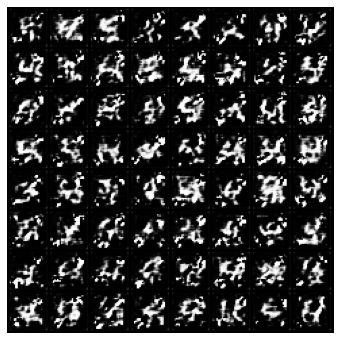

In [58]:
digit = 4 #@param {'type':'integer'}
sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 500 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
latent_score_model.eval()
## Generate samples using the specified sampler.
samples_z = sampler(latent_score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        x_shape=(4,10,10),
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [59]:
# play with architecturs
latent_score_model = torch.nn.DataParallel(
    Latent_UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn,
                channels=[4, 16, 32, 64], ))
latent_score_model = latent_score_model.to(device)

train_diffusion_model(latent_dataset, score_model,
                      n_epochs =   100,
                      batch_size =  1024,
                      lr=10e-4,
                      model_name="transformer_latent")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/tmp/ipykernel_315467/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1024, 4, 10, 10] to have 1 channels, but got 4 channels instead

### Examine Samples

Below, we examine some samples in more detail to study the image generation quality. You may see some pretty weird stuff here.

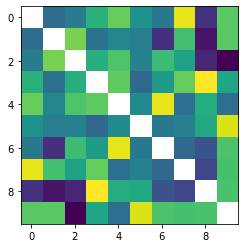

In [ ]:
cossim_mat = visualize_digit_embedding(latent_score_model.module.cond_embed.weight.data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


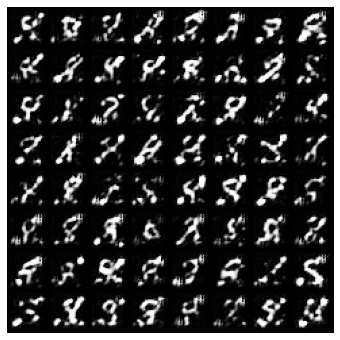

In [ ]:
digit = 8 #@param {'type':'integer'}
sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 250 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
latent_score_model.eval()
## Generate samples using the specified sampler.
samples_z = sampler(latent_score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        x_shape=(4,10,10),
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


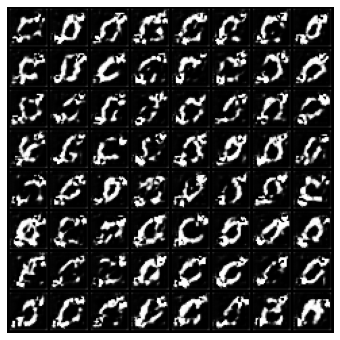

  0%|          | 0/250 [00:00<?, ?it/s]

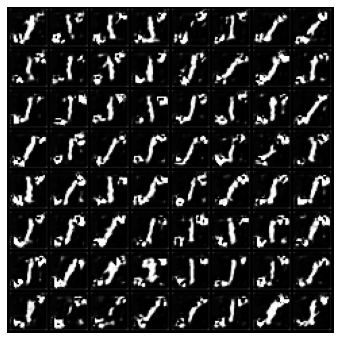

  0%|          | 0/250 [00:00<?, ?it/s]

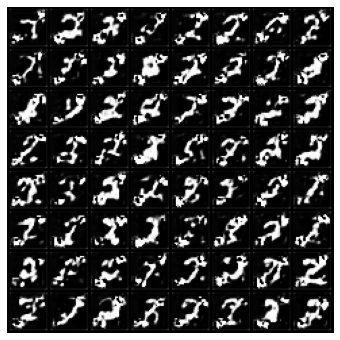

  0%|          | 0/250 [00:00<?, ?it/s]

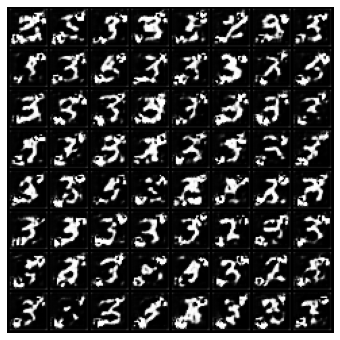

  0%|          | 0/250 [00:00<?, ?it/s]

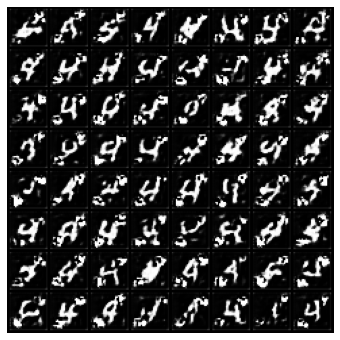

  0%|          | 0/250 [00:00<?, ?it/s]

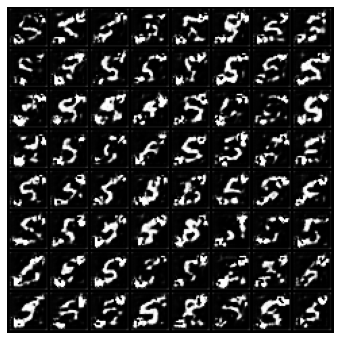

  0%|          | 0/250 [00:00<?, ?it/s]

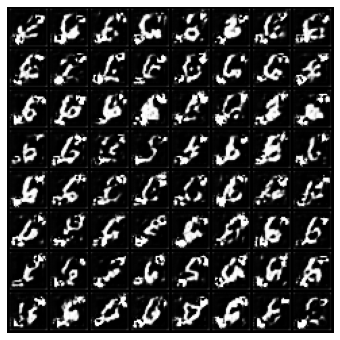

  0%|          | 0/250 [00:00<?, ?it/s]

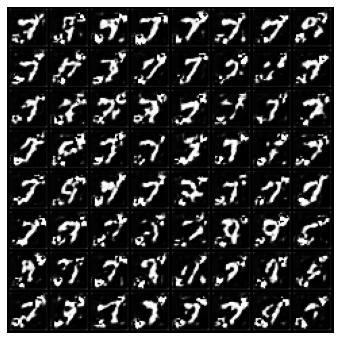

  0%|          | 0/250 [00:00<?, ?it/s]

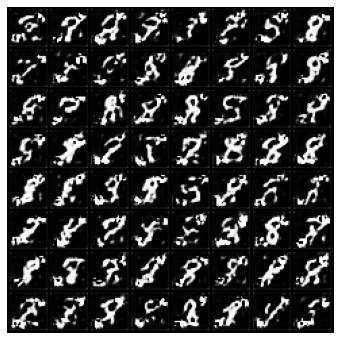

  0%|          | 0/250 [00:00<?, ?it/s]

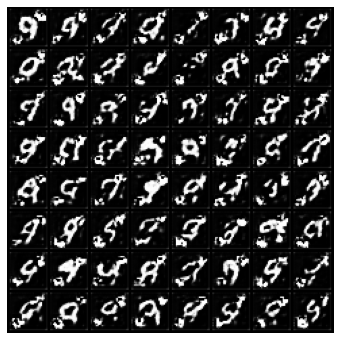

In [ ]:
def save_samples_latents(latent_score_model, suffix):
  for digit in range(10):
    sample_batch_size = 64 #@param {'type':'integer'}
    num_steps = 250 #@param {'type':'integer'}
    sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
    latent_score_model.eval()
    ## Generate samples using the specified sampler.
    samples_z = sampler(latent_score_model, 
            marginal_prob_std_fn,
            diffusion_coeff_fn, 
            sample_batch_size, 
            num_steps=num_steps,
            device=device,
            x_shape=(4,10,10),
            y=digit*torch.ones(sample_batch_size, dtype=torch.long))

    ## Sample visualization.
    decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
    sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))
    sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
    plt.imsave(f"latent_diffusion{suffix}_digit%d.png"%digit, sample_np,)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_np, vmin=0., vmax=1.)
    plt.show()
save_samples_latents(latent_score_model, "_restanh")

## Save your progress!

In [ ]:
%cp ckpt*.pth /content/drive/MyDrive/MLFS_StableDiffusionDemo

In [ ]:
!du -sh ckpt*.pth

16K	ckpt_ae.pth
1.2M	ckpt_latent_diff_transformer.pth


In [ ]:
# %mkdir /content/drive/MyDrive/MLFS_StableDiffusionDemo/imgs
%cp  *.png /content/drive/MyDrive/MLFS_StableDiffusionDemo/imgs